In [1]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

import pandas as pd


In [2]:
import quandl

In [3]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES, DTYPE_TO_STATE_SERIES

from filterflow.observation.base import ObservationModelBase, ObservationSampler

from filterflow.transition.linear import LinearTransitionModel1d
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import RicattiSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

## Download data

In [4]:
if "QUANDL_KEY" in os.environ:
    quandl.ApiConfig.api_key = os.environ['QUANDL_KEY']

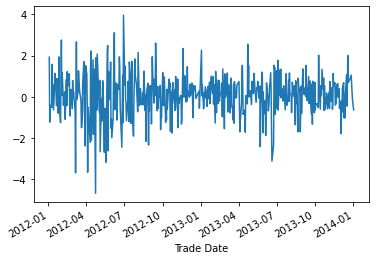

In [5]:
d =  quandl.get("NASDAQOMX/OMXS30", start_date="2012-01-02", end_date="2014-01-02")

y = np.log(d['Index Value']).diff()[1:] * 100

y.plot()

References:
- [Simulated likelihood inference for stochastic volatility
models using continuous particle filtering](https://www.stats.ox.ac.uk/~doucet/pitt_malik_doucet_continuousparticlefilterSVmodel.pdf)
- [Filtering and Estimation for a Class
of Stochastic Volatility Models with Intractable
Likelihoods](https://projecteuclid.org/download/pdfview_1/euclid.ba/1522202635)
- [Towards Smooth Particle Filters for
Likelihood Estimation with
Multivariate Latent Variables
](https://www.cs.ubc.ca/grads/resources/thesis/Nov08/Lee_Anthony.pdf)

Basic Model

$y_t = \epsilon_t \exp\big(\frac{h_t}{2}\big)$

$h_{t+1} = \mu(1 − \phi) + \phi h_t + \sigma_\eta \eta_t$, $t = 1,..., T,$

$h_0 \sim \mathcal{N}\big(0, \frac{\sigma^2_η}{(1 − \phi^2)}\big)$

$$\epsilon_t \sim \mathcal{N}(0,1)$$
$$\eta_t \sim \mathcal{N}(0,1)$$
            

In [6]:
state_dim = 1
T = 300

In [7]:
# Variables to train
# phi
init_phi = 0.5
true_phi = tf.Variable(init_phi, trainable = False)

# mu
init_mu = 0.25
true_mu = tf.Variable(init_mu, trainable = False)

# sigma
init_sig = 0.1
true_sig = tf.Variable(init_sig, trainable = False)

## Transition

In [8]:
zeros = tf.zeros(state_dim, dtype=float)
transition_noise = tfp.distributions.Normal(zeros, true_sig)

transition_matrix = true_phi

add_term =  true_mu*(1.-true_phi)

transition_model = LinearTransitionModel1d(transition_matrix, add_term, transition_noise)

## Observation Model

In [9]:
class SVObservationModel(ObservationSampler):
    
    def __init__(self):
        self.normal = tfp.distributions.Normal(0., 1.)

    def loglikelihood(self, state: State, observation: tf.Tensor):
        """Computes the loglikelihood of an observation given proposed particles
        :param state: State
            Proposed (predicted) state of the filter given State at t-1 and Observation
        :param observation: ObservationBase
            User/Process given observation
        :return: a tensor of loglikelihoods for all particles
        :rtype: tf.Tensor
        """
        batch_size, n_particles, dim = state.particles.shape
        log_vol = state.particles
        vol = tf.exp(log_vol/2)
        
        log_prob = self.normal.log_prob(observation/vol)
        return tf.reshape(log_prob, [batch_size, n_particles])

    def sample(self, state: State):
        """Samples a new observation conditionally on latent state
        :param state: State
            State of the filter at t
        :return: observartion 
        :rtype: Observation
        """
        log_vol = state.particles
        vol = tf.exp(log_vol/2)
        observation = vol * self.normal.sample([state.batch_size, state.n_particles,1])
        return observation
        

In [10]:
observation_model = SVObservationModel()

## State Space Model

In [11]:
initial_value = tfp.distributions.Normal(0., 1.).sample()* tf.sqrt(true_sig**2 / (1-true_phi**2))
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
states, observations = ss_model(initial_value, T)

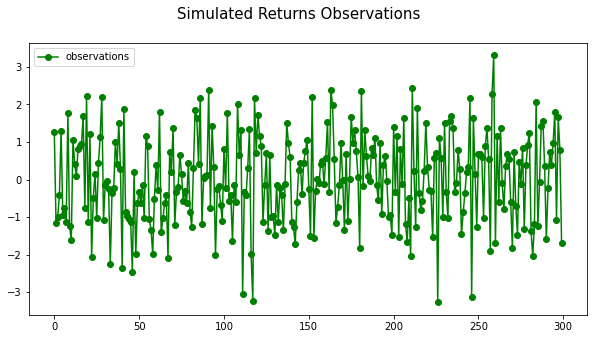

In [12]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

linspace  = np.arange(T)
fig, axes = plt.subplots(nrows=1, figsize=(10, 5))
axes.plot(linspace, np_obs, marker='o', color='g', label='observations')
#axes.plot(np_states[:, 1], color='b', label='$h_t$')
_ = axes.legend(loc='upper left')
_ = fig.suptitle('Simulated Returns Observations', fontsize=15)

In [13]:
obs_data = tf.data.Dataset.from_tensor_slices(observations)

## Particle Filter

In [14]:
# store observations
batch_size = 1
n_particles = 100
dimension = 1

In [15]:
# Variables to train
# phi
init_phi = tf.constant(np.random.random(), dtype=float)
phi = tf.Variable(init_phi, trainable = True)

# mu
init_mu = 0.25
mu = tf.Variable(init_mu, trainable = False)

# sigma
init_sig = 0.5
sig = tf.Variable(init_sig, trainable = False)

In [16]:
# initial state
normal_dist = tfp.distributions.Normal(0., 1.)
initial_particles = normal_dist.sample( [batch_size, n_particles, state_dim])* tf.sqrt(sig**2 / (1-phi**2))

initial_particles = tf.cast(initial_particles, dtype=float)

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods)

In [17]:
zeros = tf.zeros(state_dim, dtype=float)
transition_noise = tfp.distributions.Normal(zeros, sig**2)

learnable_transition_matrix = phi

add_term =  mu*(1.-phi)

transition_model = LinearTransitionModel1d(learnable_transition_matrix, add_term, transition_noise)

# proposal
proposal_model = BootstrapProposalModel(transition_model)

In [18]:


# resampling criterion
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))

# resampling methods
systematic = SystematicResampler()
multinomial = MultinomialResampler()


epsilon = tf.constant(0.25)
scaling = tf.constant(0.9)
regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4)


In [19]:
particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, regularized)

In [20]:
recorded_states = particle_filter(initial_state, observation_series=obs_data, n_observations=T)

In [21]:
recorded_states  = attr.evolve(recorded_states)

In [22]:
# compute states
computed_states = []
for t, observation in enumerate(observations):
    state = recorded_states.read(tf.constant(t, dtype=tf.int32))
    log_weights = state.log_weights.numpy()
    particles = state.particles.numpy()[:,:,0]
    weights = np.exp(log_weights)
    computed_state = np.sum((weights * particles), axis=1)
    computed_states.append(computed_state)
    
computed_states = np.array(computed_states).flatten()

In [23]:
ht = np.array([state.particles.numpy() for state in states]).squeeze()

In [24]:
obs = np.array([ob.numpy() for ob in observations]).squeeze()

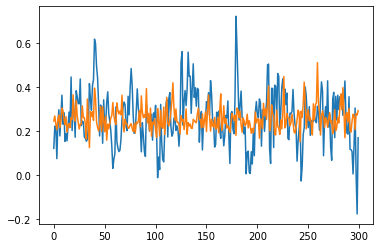

In [25]:
plt.plot(ht)
plt.plot(computed_states)

# Backprop

In [ ]:
# Create an optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.01)
tqdm_callback = tfa.callbacks.TQDMProgressBar()

@tf.function
def loss_func(smc):
    tf.random.set_seed(75)
    final_state = smc(initial_state, observation_series=obs_data, n_observations=T, return_final=True)
    return -tf.reduce_mean(final_state.log_likelihoods), tf.math.reduce_std(final_state.log_likelihoods)

@tf.function
def train_one_step(optimizer, smc):
    var_list= [learnable_transition_matrix]
    with tf.GradientTape() as tape:
        tape.watch(var_list)
        loss, _ = loss_func(smc)
    grads = tape.gradient(loss, var_list)
    clip = lambda val: tf.clip_by_value(val, -100., 100.)
    grads = [clip(grad) for grad in grads]
    optimizer.apply_gradients(zip(grads,var_list))
    return loss, grads

@tf.function
def train(optimizer, smc, num_steps = 101):
    assign_1 = learnable_transition_matrix.assign(init_phi)
    loss_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    grad_tensor_array = tf.TensorArray(dtype=tf.float32, size=num_steps, dynamic_size=False, element_shape=[])
    with tf.control_dependencies([assign_1]):
        for step in tf.range(num_steps):
            loss, grads = train_one_step(optimizer, smc)
            tf.print('Step', step, '/', num_steps - 1, ': loss = ', loss, end='\r')
            tf.print('transition', learnable_transition_matrix, end='\r')
            
            loss_tensor_array = loss_tensor_array.write(step, loss)
            grad_tensor_array = grad_tensor_array.write(step, tf.reduce_max(tf.abs(grads)))
    
    return (loss_tensor_array.stack(), grad_tensor_array.stack(), 
            tf.convert_to_tensor(learnable_transition_matrix))
            

In [26]:
pf_loss, pf_grad, pf_learned_transition_matrix = train(optimizer, particle_filter, num_steps=500)

In [35]:
pf_learned_transition_matrix

<tf.Tensor: shape=(), dtype=float32, numpy=0.32221478>

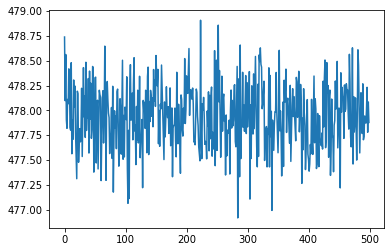

In [36]:
plt.plot(pf_loss.numpy())